In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


In [13]:
file_path = "datasets/KDDTrain+.txt"  # or use "KDDTrain+.csv" if converted to CSV

columns = [
    "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
    "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "difficulty"
]

if file_path.endswith(".csv"):
    df = pd.read_csv(file_path)
    if df.shape[1] != len(columns):
        df.columns = columns
else:
    df = pd.read_csv(file_path, header=None, names=columns, sep=",")


In [14]:
original_df = df.copy()
df.drop(columns=["label", "difficulty"], inplace=True)

for col in ['protocol_type', 'service', 'flag']:
    df[col] = LabelEncoder().fit_transform(df[col])


In [15]:
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df['anomaly'] = model.fit_predict(df)


Anomaly Counts:
 anomaly
 1    119676
-1      6297
Name: count, dtype: int64


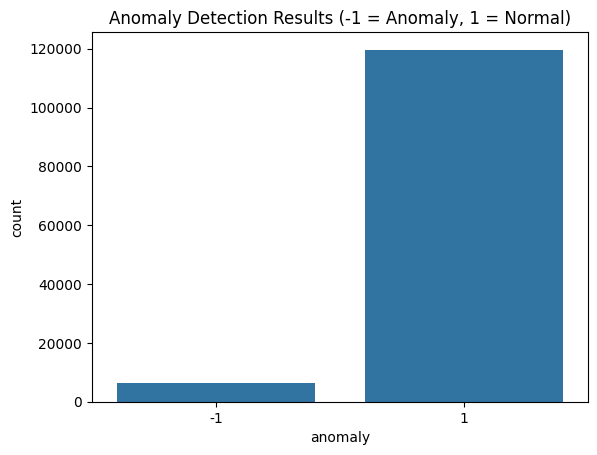

In [16]:
print("Anomaly Counts:\n", df['anomaly'].value_counts())

sns.countplot(x='anomaly', data=df)
plt.title("Anomaly Detection Results (-1 = Anomaly, 1 = Normal)")
plt.show()


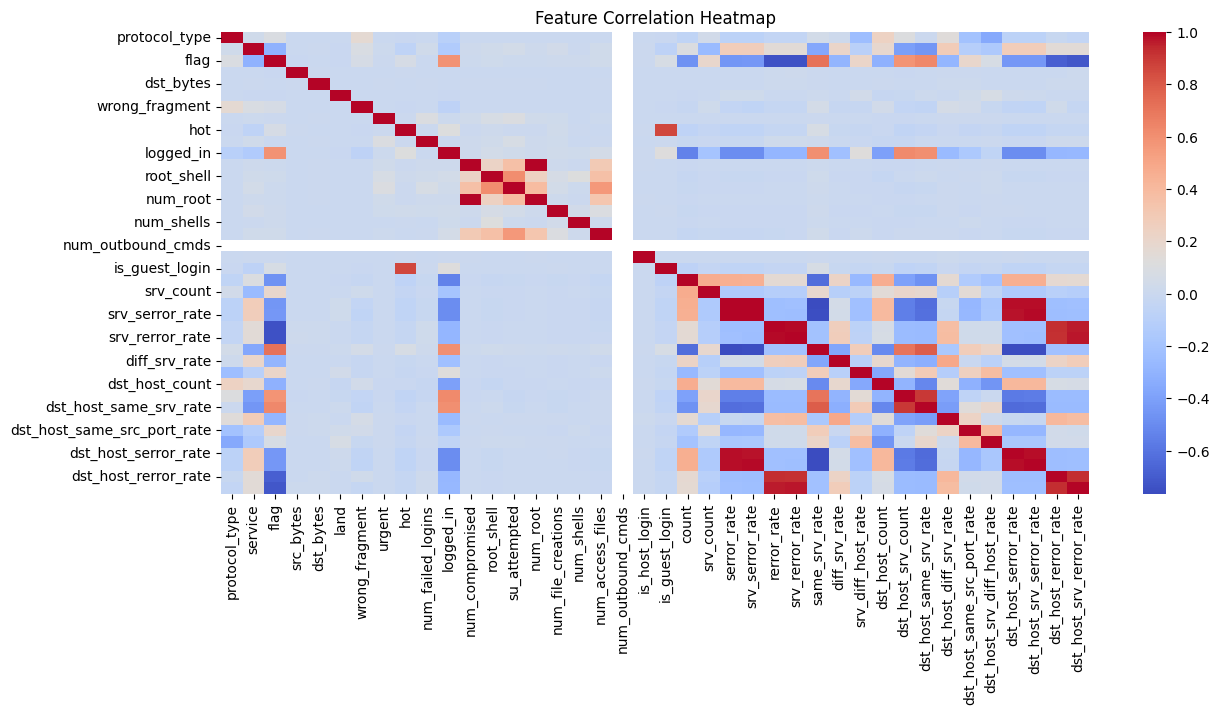

In [17]:
plt.figure(figsize=(14, 6))
sns.heatmap(df.drop(columns=['anomaly']).corr(), cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


In [18]:
try:
    top_proto = original_df.loc[df['anomaly'] == -1, 'protocol_type'].mode()[0]
    top_service = original_df.loc[df['anomaly'] == -1, 'service'].mode()[0]
    bytes_ratio = (
        df[df['anomaly'] == -1]['src_bytes'].mean() /
        df[df['anomaly'] == 1]['src_bytes'].mean()
    )
    print(f"Top Protocol in Anomalies: {top_proto}")
    print(f"Top Service in Anomalies: {top_service}")
    print(f"src_bytes is {bytes_ratio:.2f}x higher on average in anomalies.")
except Exception as e:
    print("Summary generation failed:", e)


Top Protocol in Anomalies: tcp
Top Service in Anomalies: private
src_bytes is 70.87x higher on average in anomalies.


In [19]:
anomalies = df[df['anomaly'] == -1]
anomalies.to_csv("anomaly_report.csv", index=False)
print("Anomaly report saved to 'anomaly_report.csv'")


Anomaly report saved to 'anomaly_report.csv'
